#### Import libraries and load our data

#### Import libraries and load our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Load datasets
train = pd.read_csv('../CapstoneTwo/train_final.csv')
test = pd.read_csv('../CapstoneTwo/test_final.csv')

#### Identify our dependent and independent variables

In [4]:
#Get X and y
X = train.drop(columns='WnvPresent')._get_numeric_data()
y = train['WnvPresent']

#### Split the data into train and test subsamples

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Oversample

In [6]:
os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)

#### Scale data to prep for model creation

In [7]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [8]:
X_train.head()

,Latitude,Longitude,Year,Month,Week,Day,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tmax_1w,Tmax_2w,Tmax_3w,Tmin_1w,Tmin_2w,Tmin_3w,Tavg_1w,Tavg_2w,Tavg_3w,Depart_1w,Depart_2w,Depart_3w,DewPoint_1w,DewPoint_2w,DewPoint_3w,WetBulb_1w,WetBulb_2w,WetBulb_3w,Heat_1w,Heat_2w,Heat_3w,Cool_1w,Cool_2w,Cool_3w,PrecipTotal_1w,PrecipTotal_2w,PrecipTotal_3w,StnPressure_1w,StnPressure_2w,StnPressure_3w,SeaLevel_1w,SeaLevel_2w,SeaLevel_3w,ResultSpeed_1w,ResultSpeed_2w,ResultSpeed_3w,ResultDir_1w,ResultDir_2w,ResultDir_3w,AvgSpeed_1w,AvgSpeed_2w,AvgSpeed_3w
0,0.596795,0.693036,1.000000,0.8,0.842105,0.850746,0.0,0.0,1.0,0.0,0.0,0.0,0.679487,0.771429,0.753623,0.866667,0.823529,0.775862,0.000000,0.585366,0.851064,0.165877,0.175620,0.364286,0.374150,0.517361,0.428571,0.596226,0.296912,0.559392,0.570393,0.324251,0.517829,0.543668,0.262873,0.525245,0.541552,0.333333,0.718062,0.654605,0.301333,0.507599,0.567,0.235669,0.471664,0.538915,0.444444,0.279070,0.195122,0.145098,0.464876,0.472834,2.674858e-01,0.223846,0.253775,0.912310,0.665986,0.591449,0.933007,0.664055,0.584662,0.737346,0.761011,0.573354,0.280528,0.573737,0.625373,0.697708,0.774638,0.567308
1,0.046677,0.516794,1.000000,0.6,0.526316,0.537313,1.0,0.0,0.0,0.0,0.0,0.0,0.538462,0.700000,0.637681,0.366667,0.485294,0.517241,0.000000,0.390244,0.255319,0.867299,0.000000,0.535714,0.510204,0.621528,0.114286,0.577358,0.612827,0.469613,0.552795,0.643052,0.494574,0.579694,0.601626,0.464959,0.550358,0.320755,0.096916,0.121711,0.610667,0.525836,0.577,0.576433,0.451554,0.549528,0.000000,0.069767,0.048780,0.447059,0.309917,0.430250,1.143667e-01,0.180000,0.144599,0.596965,0.493361,0.399842,0.593137,0.492654,0.391800,0.537620,0.486134,0.452048,0.475248,0.707071,0.619403,0.603152,0.581884,0.527149
2,0.885357,0.101112,0.666667,0.8,0.789474,0.828358,1.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.128571,0.057971,0.000000,0.000000,0.000000,0.857143,0.000000,0.822695,0.189573,0.000000,1.000000,1.000000,0.097222,0.271429,0.083019,0.280285,0.262431,0.386128,0.217984,0.244961,0.394105,0.200542,0.230595,0.368189,0.226415,0.220264,0.305921,0.242667,0.275076,0.430,0.187898,0.202925,0.395047,0.685185,0.575581,0.402439,0.149020,0.159091,0.308370,9.451796e-03,0.036154,0.001742,0.881956,0.716037,0.624703,0.875817,0.713026,0.619590,0.303694,0.819739,0.582685,0.778878,0.608081,0.526866,0.212034,0.758696,0.531109
3,0.340778,0.570783,1.000000,0.6,0.684211,0.694030,0.0,1.0,0.0,0.0,0.0,0.0,0.782051,0.714286,0.782609,0.666667,0.750000,0.758621,0.000000,0.634146,0.695035,0.530806,0.000000,0.578571,0.557823,0.239583,0.257143,0.169811,0.840855,0.795580,0.697723,0.779292,0.648062,0.601528,0.799458,0.717408,0.638415,0.685535,0.634361,0.407895,0.730667,0.676292,0.609,0.754777,0.687386,0.609670,0.000000,0.000000,0.008130,0.725490,0.623967,0.530103,2.098720e-17,0.048462,0.059233,0.856661,0.805924,0.808393,0.839869,0.780607,0.793470,0.783858,0.516313,0.359772,0.547855,0.577778,0.601493,0.577364,0.442754,0.259615
4,0.420811,0.419619,0.000000,0.6,0.526316,0.529851,0.0,1.0,0.0,0.0,0.0,0.0,0.871795,0.857143,0.905797,0.700000,1.000000,1.000000,0.000000,0.853659,0.248227,0.872038,0.283058,0.235714,0.210884,0.392361,0.671429,0.490566,0.855107,0.825967,0.752588,0.861035,0.792248,0.718341,0.848238,0.804069,0.726472,0.635220,0.629956,0.427632,0.824000,0.776596,0.700,0.837580,0.780622,0.707547,0.000000,0.000000,0.000000,0.803922,0.747934,0.647577,3.903592e-01,0.416154,0.434959,0.502530,0.401430,0.504355,0.491830,0.379040,0.483675,0.224350,0.216150,0.219803,0.438944,0.395960,0.419403,0.216332,0.334058,0.250000


# 1. Logistic Regression

#### Fit Logistic Regression Classifier

In [9]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
y_pred_training = lr_clf.predict(X_train)
y_pred_probs = lr_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_probs)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8056133625410734

In [10]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      7963
           1       0.79      0.87      0.83      7963

    accuracy                           0.82     15926
   macro avg       0.82      0.82      0.82     15926
weighted avg       0.82      0.82      0.82     15926



In [11]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1992
           1       0.14      0.65      0.23       110

    accuracy                           0.78      2102
   macro avg       0.56      0.71      0.55      2102
weighted avg       0.93      0.78      0.84      2102



#### Create Confusion Matrix Plots

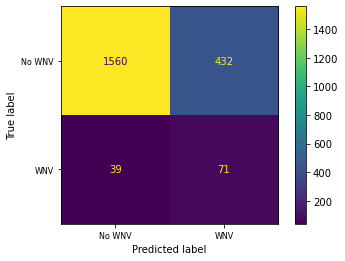

In [12]:
cm = confusion_matrix(y_test, y_pred, labels = lr_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


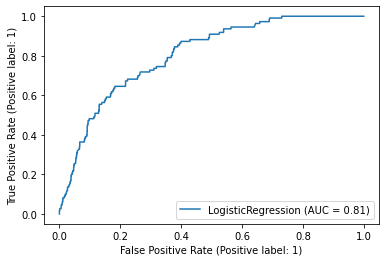

In [13]:
plot_roc_curve(lr_clf, X_test, y_test)

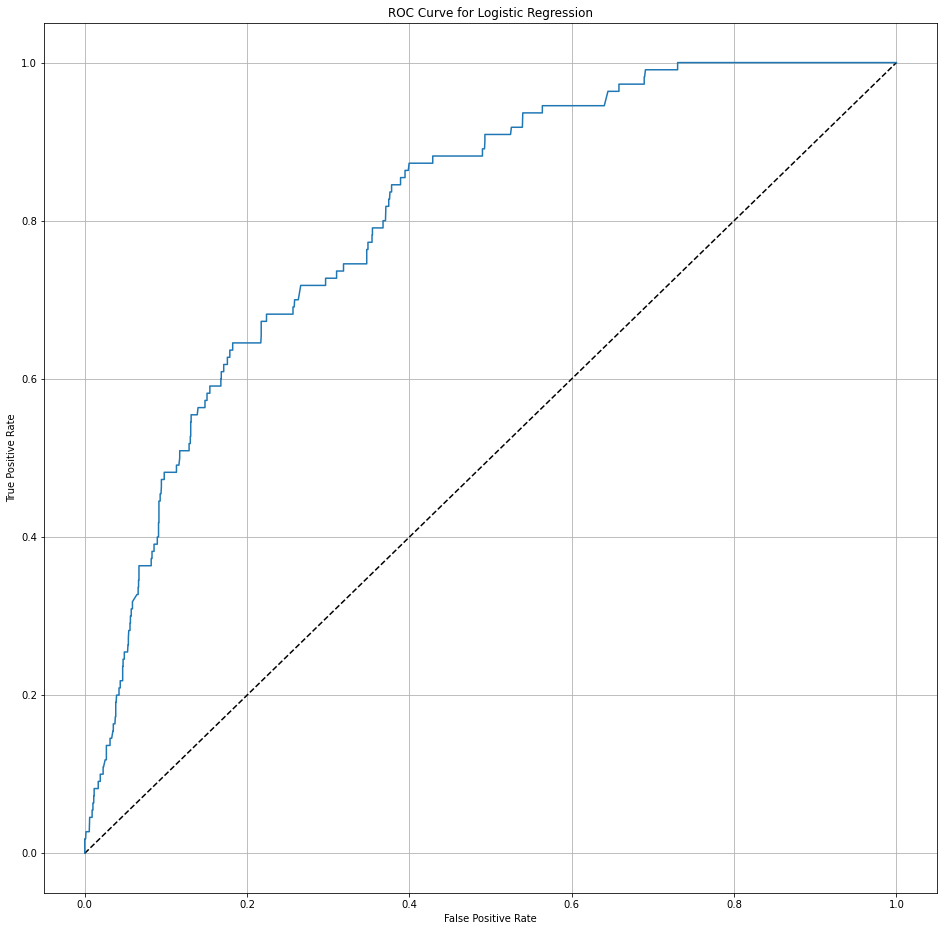

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.grid(True)
plt.show()

#### Hyperparameter Tuning Using GridSearchCV

# 2. Random Forest Classifier

#### Fit Random Forest Classifier

In [15]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state = 42,n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
y_pred_training = rf_clf.predict(X_train)
y_pred_probs = rf_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_probs)

0.7631868382621395

In [16]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7963
           1       0.98      0.99      0.98      7963

    accuracy                           0.98     15926
   macro avg       0.98      0.98      0.98     15926
weighted avg       0.98      0.98      0.98     15926



In [17]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1992
           1       0.18      0.38      0.24       110

    accuracy                           0.87      2102
   macro avg       0.57      0.64      0.59      2102
weighted avg       0.92      0.87      0.90      2102



#### Create Confusion Matrix Plots

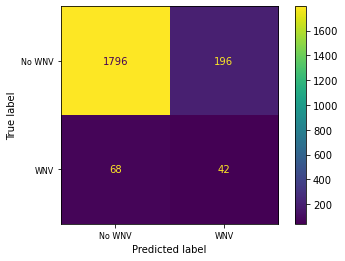

In [18]:
cm = confusion_matrix(y_test, y_pred, labels = rf_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


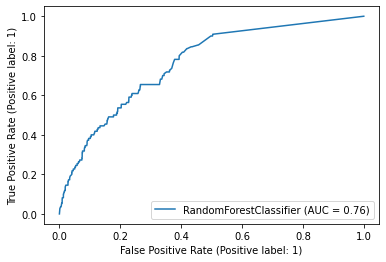

In [19]:
plot_roc_curve(rf_clf, X_test, y_test)

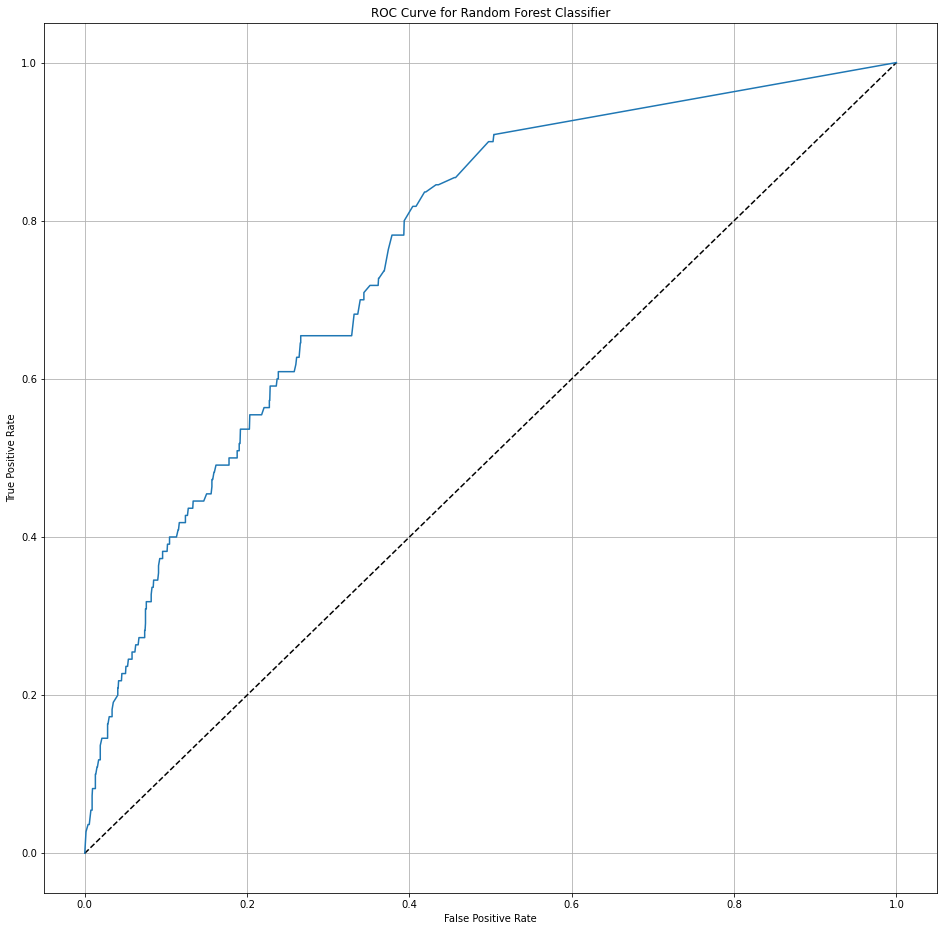

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


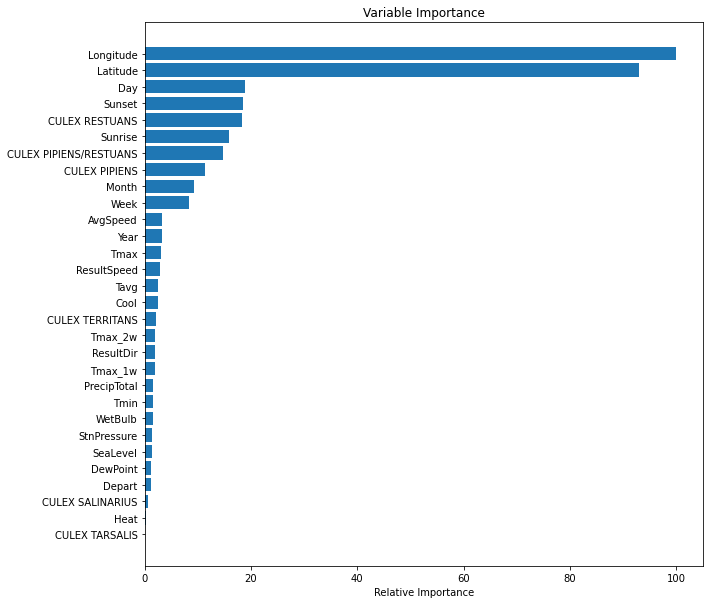

In [21]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

In [22]:
#shap.initjs()

#explainer = shap.TreeExplainer(rf_clf)
#shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values,X_train, max_display=40)

#### Hyperparameter Tuning Using GridSearchCV

# 3. Extreme Gradient Boosting

#### Fit XGB Classifier

In [23]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_pred_training = xgb_clf.predict(X_train)
y_pred_probs = xgb_clf.predict_proba(X_test)[:,1]


roc_auc_score(y_test, y_pred_probs)

0.8110076670317634

In [24]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7963
           1       0.97      0.97      0.97      7963

    accuracy                           0.97     15926
   macro avg       0.97      0.97      0.97     15926
weighted avg       0.97      0.97      0.97     15926



In [25]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1992
           1       0.24      0.33      0.28       110

    accuracy                           0.91      2102
   macro avg       0.60      0.63      0.61      2102
weighted avg       0.92      0.91      0.92      2102



#### Create Confusion Matrix Plots

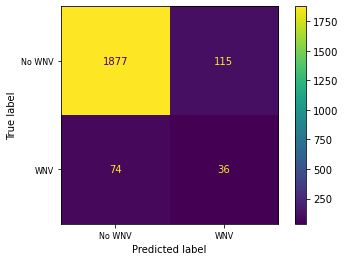

In [26]:
cm = confusion_matrix(y_test, y_pred, labels = xgb_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


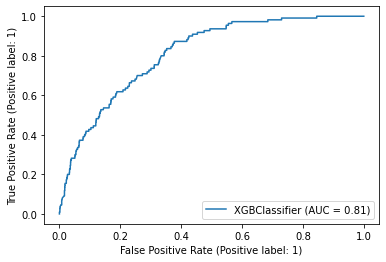

In [27]:
plot_roc_curve(xgb_clf, X_test, y_test)

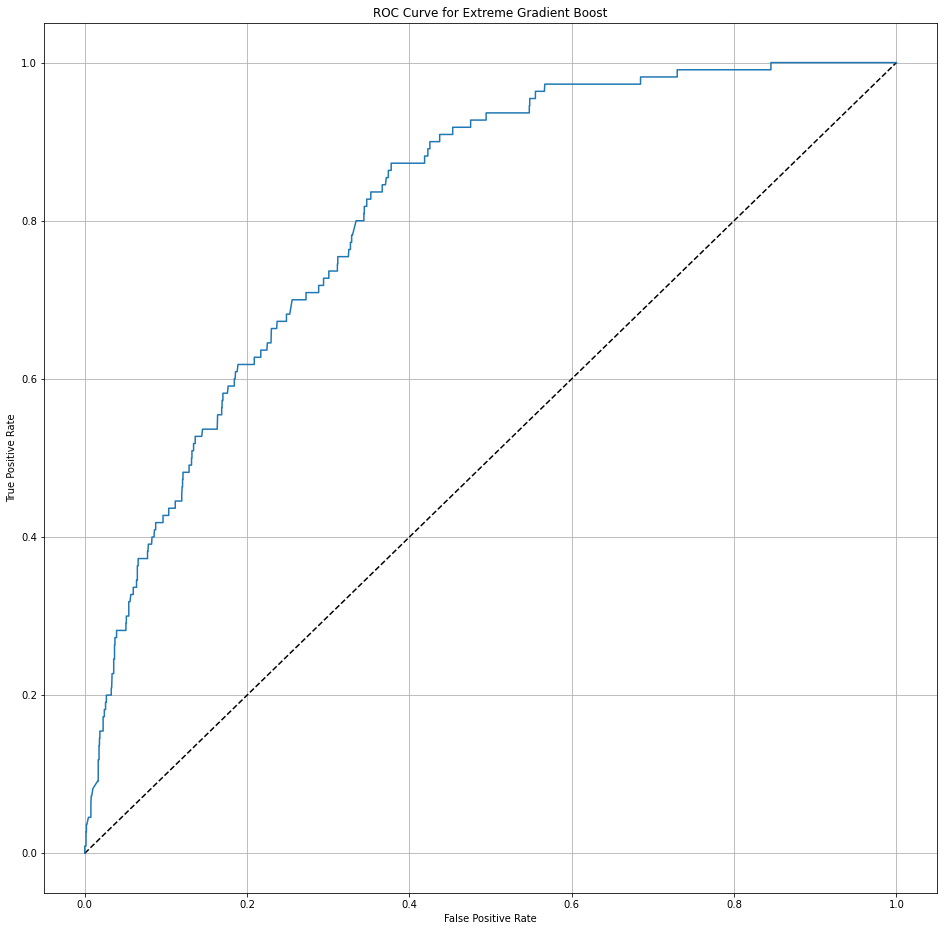

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extreme Gradient Boost')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


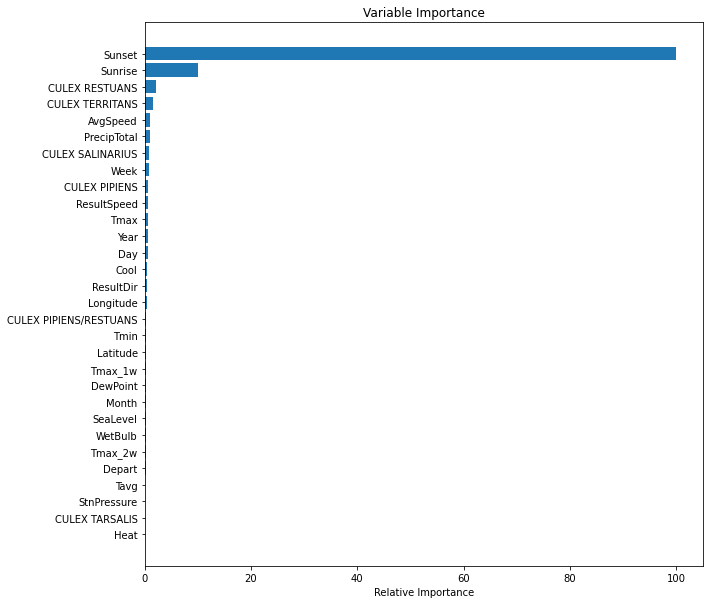

In [29]:
feature_importance = xgb_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


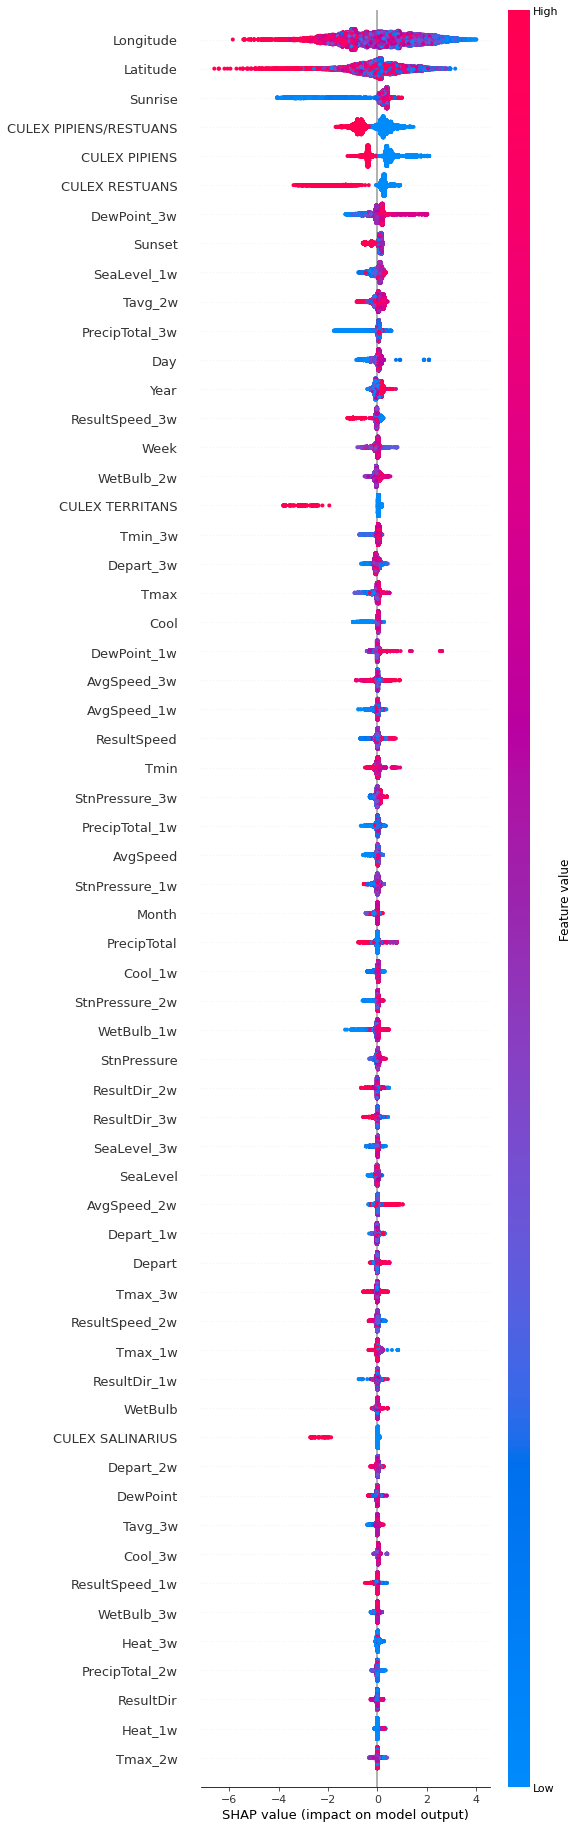

In [30]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, max_display=60)

#### Hyperparameter Tuning Using GridSearchCV

### Notes:
### 1. Still have to figure out GridSearchCV - the amount of hyperparameters to tune and where to start is overwhelming.
### 2. Latitude and Longitude seem disproporionately important in my Random Forest Classifier.
### 3. SHAP feature importances don't seem to agree with SKlearns feature importances
#### 4. Fixed ROC curve. Also, SMOTE just worked much better than undersampling no matter what I tried.
